# data cleaning

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,  TfidfTransformer
import jieba
from pycantonese.word_segmentation import Segmenter
import pycantonese
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_msg_valid = pd.read_excel('../data/good_bad_chat_history_total_20240117.xlsx')

In [3]:
df_pp_count = df_msg_valid.drop_duplicates(subset=['conversationId'])[['conversationId', 'max_pp']]
df_pp_count_des = df_pp_count.describe()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']

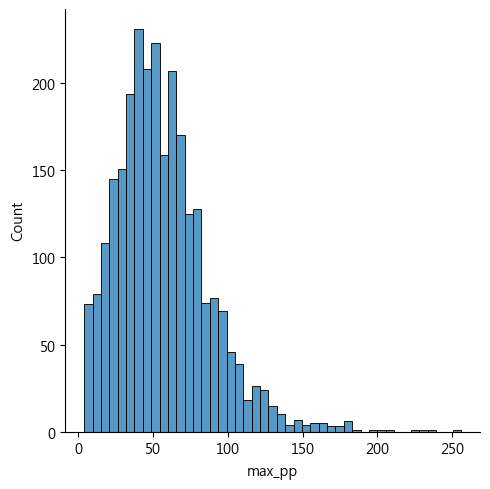

In [5]:
sns.displot(df_pp_count, x='max_pp')

In [6]:
# calculate Interquantile Range
print(df_pp_count_des.loc['75%','max_pp']+1.5*(df_pp_count_des.loc['75%','max_pp']-df_pp_count_des.loc['25%','max_pp']))

131.5


In [7]:
# select sessions with total message exchange count no less than 4 and remove outliers using 1.5*IQR to ensure data balance
valid_convId_pp = df_pp_count[(df_pp_count['max_pp']>=4)&(df_pp_count['max_pp']<=132)]['conversationId'].tolist()
len(valid_convId_pp)

2589

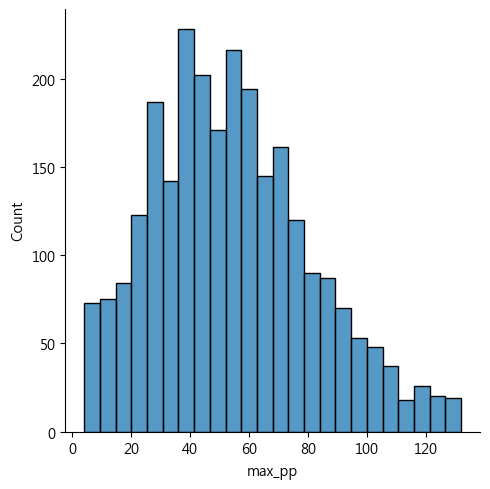

In [8]:
# draw distribution of total message exchange count after removing outliers
df_pp = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))].drop_duplicates(subset=['conversationId'])
sns.displot(df_pp, x='max_pp')

In [9]:
df_msg_validd = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))]
df_msg_validd.reset_index(inplace=True, drop=True)

In [10]:
good_bad_count = df_msg_validd.drop_duplicates(subset=['conversationId'])
good_bad_count['quality'].value_counts()

good    1993
bad      596
Name: quality, dtype: int64

# data processing

In [11]:
df_msg_valid = df_msg_validd.copy()

In [12]:
df_msg_valid = df_msg_valid[(df_msg_valid['conversationId'].isin(good_bad_count[(good_bad_count['quality'] == 'good')]['conversationId'].tolist()))]

In [13]:
df_msg_valid['msg_token_list'] = None
for i in range(len(df_msg_valid['msg_token'])):
    df_msg_valid['msg_token_list'][i] = df_msg_valid['msg_token'][i].split(' ')

In [14]:
df_msg_valid=df_msg_valid.assign(pp_percentage=df_msg_valid['pp']/df_msg_valid['max_pp'])

In [15]:
# split session into equal fifth
def df_label_category(df, cat):
    labels = np.arange(len(cat)-1)
    category = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    df['pp_category'] = pd.cut(df['pp_percentage'], labels=labels, bins=category, include_lowest=True)
    return df

n_stage=6
df_msg_valid=df_msg_valid.pipe(df_label_category, np.linspace(0, 1 , n_stage) )

In [17]:
df_msg_valid = df_msg_valid[['conversationId', 'from_whom', 'datetime', 'msg_replace', 'msg_token', 'msg_token_list', 'pp', 'max_pp', 'pp_percentage', 'pp_category']]

In [18]:
for i in range(len(df_msg_valid['msg_token_list'])):
    if df_msg_valid['from_whom'][i] == True:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'H' + df_msg_valid['msg_token_list'][i][j]
    else:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'C' + df_msg_valid['msg_token_list'][i][j]

In [19]:
df_msg_valid['msg_token'] = [' '.join(i) for i in df_msg_valid['msg_token_list']]

In [20]:
df_msg_valid['pp_category'] = df_msg_valid['pp_category'].fillna(0)

# hmm training

## message-based tf-idf

In [21]:
# Instantiate TfidfVectorizer with custom stopwords
tfidf_vectorizer = TfidfVectorizer(token_pattern='\\b\\w+\\b', min_df=2)  # , stop_words = list(low_freq_words)min_df to avoid very rare words

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_msg_valid['msg_token'])

# Get feature names and their corresponding TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Create a DataFrame for TF-IDF scores
tfidf_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})

In [23]:
# Filter based on a score threshold (3rd quantile)
threshold = tfidf_df['score'].describe()['75%']

low_tfidf_words = list(tfidf_df.loc[tfidf_df['score']<threshold]['word'])

In [24]:
cv = CountVectorizer(min_df = 2, max_df = 1.0, token_pattern ='\\b\\w+\\b', stop_words = low_tfidf_words) #+list(low_freq_words)
cv.fit(df_msg_valid['msg_token'])
X = cv.transform(df_msg_valid['msg_token'])

In [25]:
X

<166539x5883 sparse matrix of type '<class 'numpy.int64'>'
	with 471184 stored elements in Compressed Sparse Row format>

## remove messages with no bags-of-words

In [27]:
## Remove conversation without any BoW inside
threshold = 1
X_final = X[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final = df_msg_valid.iloc[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final.reset_index(inplace = True, drop = True)

In [28]:
X_final

<70968x5883 sparse matrix of type '<class 'numpy.int64'>'
	with 346759 stored elements in Compressed Sparse Row format>

In [30]:
final_conv_msg_count = pd.DataFrame(df_msg_valid_final['conversationId'].value_counts())
final_conv_msg_count.reset_index(inplace=True,drop=False)

# prepare emission probability matrix

In [31]:
emission=pd.DataFrame(X_final.toarray())
df_msg_valid_final.pp_category=df_msg_valid_final.pp_category.astype(int)
emission["stage"]=df_msg_valid_final.pp_category

In [32]:
emission=emission.groupby('stage').sum()

In [33]:
emission+=1

In [34]:
emission

,0,1,2,3,4,5,6,7,8,9,...,5873,5874,5875,5876,5877,5878,5879,5880,5881,5882
stage,,,,,,,,,,,,,,,,,,,,,
0,14,4,28,25,5,1,2,1,9,1,...,65,1,27,18,1,4,16,8,12,6
1,20,2,27,42,8,1,2,1,20,2,...,46,2,25,2,3,7,18,11,20,2
2,19,2,36,29,9,2,6,1,21,2,...,38,4,18,5,2,4,13,4,20,6
3,10,1,62,32,13,3,2,1,19,4,...,13,2,11,3,1,5,16,4,18,3
4,12,7,35,48,20,6,4,11,22,4,...,7,1,4,3,2,6,11,2,12,2


# training HMM

In [35]:
import hmmlearn as hmmlearn
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor

In [36]:
df_emission_scale=emission.apply(lambda x:x/emission.sum(axis=1),axis=0)

## 5 stage HMM
chmm=hmmlearn.hmm.PoissonHMM(n_components=5,params ='tl', init_params='', n_iter=1000, implementation ='log' ,transmat_prior=10, lambdas_prior=10)
chmm.startprob_=np.array([1, 0, 0, 0, 0])

chmm.transmat_ = np.array([[0.55 , 0.254, 0.114, 0.074, 0.008],
                            [0.002, 0.414, 0.5  , 0.075, 0.009],
                            [0.002, 0.352, 0.394, 0.232, 0.02 ],
                            [0.   , 0.088, 0.39 , 0.392, 0.13 ],
                            [0.   , 0.   , 0.   , 0.   , 1.   ]])

chmm.lambdas_=df_emission_scale

# with open("../models/poisson4stagehmm.pkl", "rb") as file: chmm=pickle.load(file)

In [37]:
df_len=df_msg_valid_final.groupby("conversationId").count()['pp_category']

In [38]:
np.round(chmm.transmat_, 3)

array([[0.55 , 0.254, 0.114, 0.074, 0.008],
       [0.002, 0.414, 0.5  , 0.075, 0.009],
       [0.002, 0.352, 0.394, 0.232, 0.02 ],
       [0.   , 0.088, 0.39 , 0.392, 0.13 ],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

In [511]:
chmm.fit(X_final.toarray(), df_len)

PoissonHMM(init_params='', lambdas_prior=10, n_components=5, n_iter=1000,
           params='tl', random_state=RandomState(MT19937) at 0x283D011D940,
           transmat_prior=10)

In [512]:
chmm.monitor_

ConvergenceMonitor(
    history=[-1324596.1430187593, -1150612.4212721812, -1128197.950655795, -1120184.1708452103, -1116393.4289782909, -1114466.453173902, -1113611.8847167369, -1113069.4985685314, -1112669.9755777426, -1112373.115044632, -1112147.7208559029, -1111964.6308135767, -1111808.0706783617, -1111675.633848116, -1111556.9230601564, -1111462.971085113, -1111391.8140141948, -1111328.2301068623, -1111268.6086985632, -1111213.5236014985, -1111166.529696517, -1111125.0747455566, -1111094.061503888, -1111069.6773637633, -1111050.4863894798, -1111031.7975409385, -1111017.007284432, -1111007.6163258653, -1111000.9180528063, -1110995.6947000592, -1110991.7906549121, -1110989.1357573655, -1110987.4011289051, -1110985.9984314512, -1110984.7590476205, -1110983.5096222234, -1110982.162156419, -1110980.740398699, -1110978.7038731643, -1110976.686239416, -1110975.8060836813, -1110975.2768645773, -1110974.8617525327, -1110974.481115497, -1110974.1233092712, -1110973.8158273424, -1110973.5972

In [40]:
boW_prob = pd.DataFrame(chmm.lambdas_, columns=cv.get_feature_names_out()).transpose()

In [41]:
boW_prob_baseline=pd.DataFrame(df_emission_scale.to_numpy(),columns=cv.get_feature_names_out()).transpose()

In [559]:
np.set_printoptions(suppress=True, precision=4)
np.round(chmm.transmat_, 4)

array([[0.0526, 0.3159, 0.3525, 0.2682, 0.0108],
       [0.0025, 0.4251, 0.1068, 0.4552, 0.0104],
       [0.0017, 0.0502, 0.4045, 0.5212, 0.0224],
       [0.    , 0.1754, 0.3166, 0.4745, 0.0335],
       [0.    , 0.    , 0.    , 0.    , 1.    ]])

# stage time allocation percentage

In [519]:
lengths = df_len.tolist()
chmm_pred_list = []

start = 0
for length in lengths:
    end = start + length
    subseq = X_final.toarray()[start:end]
    chmm_pred_list.append(chmm.predict(subseq, length))
    start = end
    
combined_pred_list = [item for sublist in chmm_pred_list for item in sublist]
df_msg_valid_final['pred_stage'] = combined_pred_list

In [521]:
# sort conversations by ID and time. Then calculate time duration between each message
df_msg_valid_final['time_diff'] = df_msg_valid_final.sort_values(by=['conversationId', 'datetime']).groupby('conversationId')['datetime'].diff().shift(-1)

# convert time duration to seconds
df_msg_valid_final['time_diff_seconds'] = df_msg_valid_final['time_diff'].dt.total_seconds()

# sum up time duration of each stage within each conversation
stage_durations = df_msg_valid_final.groupby(['conversationId', 'pred_stage'])['time_diff_seconds'].sum().reset_index()

# calculate total time duration of each conversation
total_durations = df_msg_valid_final.groupby('conversationId')['time_diff_seconds'].sum().reset_index()

# merge conversation total time duration to dataframe
stage_durations = stage_durations.merge(total_durations, on='conversationId')

# calculate percentage of each stage within each conversation
stage_durations['percentage'] = (stage_durations['time_diff_seconds_x'] / stage_durations['time_diff_seconds_y']) * 100

stage_durations

,conversationId,pred_stage,time_diff_seconds_x,time_diff_seconds_y,percentage
0,000e78ad-abcf-45b5-bfa7-f1fc29321e5f,0,140.901,3408.570,4.133728
1,000e78ad-abcf-45b5-bfa7-f1fc29321e5f,1,1208.701,3408.570,35.460648
2,000e78ad-abcf-45b5-bfa7-f1fc29321e5f,2,121.704,3408.570,3.570530
3,000e78ad-abcf-45b5-bfa7-f1fc29321e5f,3,1937.264,3408.570,56.835095
4,000e78ad-abcf-45b5-bfa7-f1fc29321e5f,4,0.000,3408.570,0.000000
...,...,...,...,...,...
5460,ffbd72b0-6f15-4ce5-a561-a55e1f249280,0,94.365,4513.015,2.090953
5461,ffbd72b0-6f15-4ce5-a561-a55e1f249280,1,146.869,4513.015,3.254343
5462,ffbd72b0-6f15-4ce5-a561-a55e1f249280,2,1416.345,4513.015,31.383565
5463,ffbd72b0-6f15-4ce5-a561-a55e1f249280,3,2256.674,4513.015,50.003689


In [547]:
#Group by 'stage' and 'group' to calculate the mean and standard error for each group and stage
grouped = stage_durations.groupby(['pred_stage'])['percentage'].agg(['mean', 'std', 'count'])
grouped['se'] = grouped['std'] / np.sqrt(grouped['count'])

In [551]:
np.round(grouped['mean'].tolist(),1)

array([ 7.5, 20.2, 28.5, 46.6,  8.2])

In [549]:
np.round(grouped['se'].tolist(),2)

array([0.32, 0.52, 0.53, 0.55, 0.54])

In [550]:
stage_durations.to_excel('../data/time_allocation_each_chat_good.xlsx', index=False)